# Setup
## Install Required Packages

In [53]:
library(corrplot)
library(DESeq2)
library(dplyr)
library(docstring)
library(eulerr)
library(ggplot2)
library(gridExtra)
library(ggsci)
library(gplots)
library(ggh4x)
library(ggvenn)
library(RColorBrewer)
library(stringr)
library(tidyr)
library(viridis)
library(wesanderson)
library(WGCNA)

# install.packages("ggvenn")
options(repr.plot.width=16, repr.plot.height=8) #make all the plots larger

corrplot 0.92 loaded



## Define Functions

In [2]:
get_table <- function(column, exp, ref, want_SE = F){
#' @title Return a cleaned version of results table from DESeq2 comparisons.

#' @description Function that returns a cleaned version of the results table containing only the 
#' LFC, padj, DE, same and SE columns if specified. A gene is considered 
#' Differentially expressed (DE) from the reference if its LFC >=2 and padj <=0.05. A 
#' gene is considered the same as reference if it has LFC <= 0.5 and padj >= 0.05.

#' @param column string. Name of the condition that you want to make a comparison of
#' @param exp string. Experimental group that must be one of the levels from the condition column
#' @param ref string. Group that must be one of the levels from the condition column to serve as a reference to compare to
#' @param want_SE binary. Value where True will export the standard error column. Default value is False. 
    
#' @export dataframe

    res_temp <- results(dds, contrast = c(column, exp, ref))
    
    #remove empty rows
    res_filtered<-res_temp[!is.na(res_temp$padj),]
    dim(res_filtered)

    #index to get required columns
    res <- as.data.frame(cbind(res_filtered[,2], res_filtered[,3], res_filtered[,6]))
    rownames(res) <- rownames(res_filtered)
    colnames(res) <- c("LFC", "lfcSE", "padj")

    # Label by Differential expression criteria
    res$DE <- ifelse(abs(res$LFC) >= 2 & res$padj <= 0.05, yes = TRUE, no = FALSE)
    
    # Label by same expression criteria - i.e. the difference between conditions is not significant
    res$same <- ifelse(res$padj > 0.05 & abs(res$LFC) < 0.5 , yes = TRUE, no = FALSE)

    #Clean the df, only return what we need
    if (want_SE == T){
        return(res)
    }
    res_cleaned <- res[c("LFC", "padj", "DE", "same")]
    return(res_cleaned)
}

In [46]:
get_same <- function(SA_df, SP_df){
#' @title Return a single dataframe describing which expression value is closest in one dataframe, neither, or both

#' @descripton Function that merges two dataframes produced by get_table() and creates a new column `which` that 
#' compares the `same` column from both dataframes to determine if gene expression in the same in one 
#' dataframe both or neither

#' @param SA_df dataframe. First dataframe to compare
#' @param SP_df dataframe. Second dataframe to compare
    
#' @export dataframe. Merged dataframe with new column which
    
    SPA <- merge(SA_df, SP_df, by = 0, suffixes = c("_SA", "_SP"))

    # Decide where the expression is the same
    SPA <- SPA %>% mutate(which = case_when(same_SA == T & same_SP == T ~ "Both", 
                                            same_SA == F & same_SP == T ~ "Parent", 
                                            same_SA == T & same_SP == F ~ "Ancestor", 
                                            .default = "Neither"))
    
    #clean the df
    rownames(SPA) <- SPA$Row.names
    return(SPA[-1])
}

In [4]:
clean_table <- function(table){
#' @title Clean table after merging
    
#' @descripton Function that removes the `Row.names` column and replaces it with actual row names

#' @param table dataframe. Table to clean up
    
#' @export dataframe. Dataframe with proper rownames
    
    rownames(table) <- table$Row.names
    table <- table %>% select(-c("Row.names"))
    
}

# Import and Filter data

In [6]:
se_read <- readRDS("se.rds")
se_read
colData(se_read)

class: RangedSummarizedExperiment 
dim: 17742 36 
metadata(0):
assays(1): counts
rownames(17742): CHLRE_01g000017v5 CHLRE_01g000033v5 ...
  CHLRE_51g761597v5 CHLRE_52g761647v5
rowData names(0):
colnames(36): 23_00_1 23_00_2 ... 54_05_2 54_05_3
colData names(0):

DataFrame with 36 rows and 0 columns

In [7]:
#Combine read data with sample data
sampleInfo <- read.csv("../Reference_Files/DE_Analysis/sampleInfo_Ancestors.csv") 

#Separate CC-2935 from the ancestor population
sampleInfo$selection <- ifelse(sampleInfo$sample == 2935, yes = "parent", no = sampleInfo$selection)
sampleInfo$groups <- paste(sampleInfo$selection, sampleInfo$assay_conc, sep = "_")

#Cleaning up
sampleInfo$selection<-as.factor(sampleInfo$selection)
sampleInfo$sample<-as.factor(as.character(sampleInfo$sample))
sampleInfo$assay_conc<-as.factor(as.character(sampleInfo$assay_conc))
sampleInfo$groups<-as.factor(as.character(sampleInfo$groups))
sampleInfo$run <- as.character(gsub(".RG.bam","",sampleInfo$run))
sampleInfo <- data.frame(sampleInfo)

#Combine data
seIdx <- match(colnames(se_read), sampleInfo$run)
colData(se_read) <- cbind(colData(se_read), sampleInfo[seIdx,])

In [8]:
#Run DESeq2
dds_subset <- DESeqDataSet(se_read, design = ~groups)
#Set ancestor at 0g/L as the reference level
dds_subset$groups <- relevel(dds_subset$groups, "ancestor_0")

In [9]:
# Prefilter for low quality genes
temp <- (as.data.frame(colData(dds_subset)))
dim(temp)

#Find the group with the smallest samples
temp %>%
    group_by(groups)%>%
    summarize(n = n())
smallestGroupSize <- 3

#Remove genes with <10 reads in <3 groups i.e. those with no expression in one group of data
keep <- rowSums(counts(dds_subset) >= 10) >= smallestGroupSize
dds_subset <- dds_subset[keep,]
dim(dds_subset)

#Removed about 560 genes

[1] 36  6

groups,n
<fct>,<int>
ancestor_0,6
ancestor_5,6
parent_0,3
parent_5,3
salt_0,6
salt_36,6
salt_5,6


[1] 17179    36

In [10]:
#Run DESeq
dds <- DESeq(dds_subset)
resultsNames(dds)
result_subset<-results(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                       "groups_ancestor_5_vs_ancestor_0"
[3] "groups_parent_0_vs_ancestor_0"   "groups_parent_5_vs_ancestor_0"  
[5] "groups_salt_0_vs_ancestor_0"     "groups_salt_36_vs_ancestor_0"   
[7] "groups_salt_5_vs_ancestor_0"

using ntop=500 top features by variance



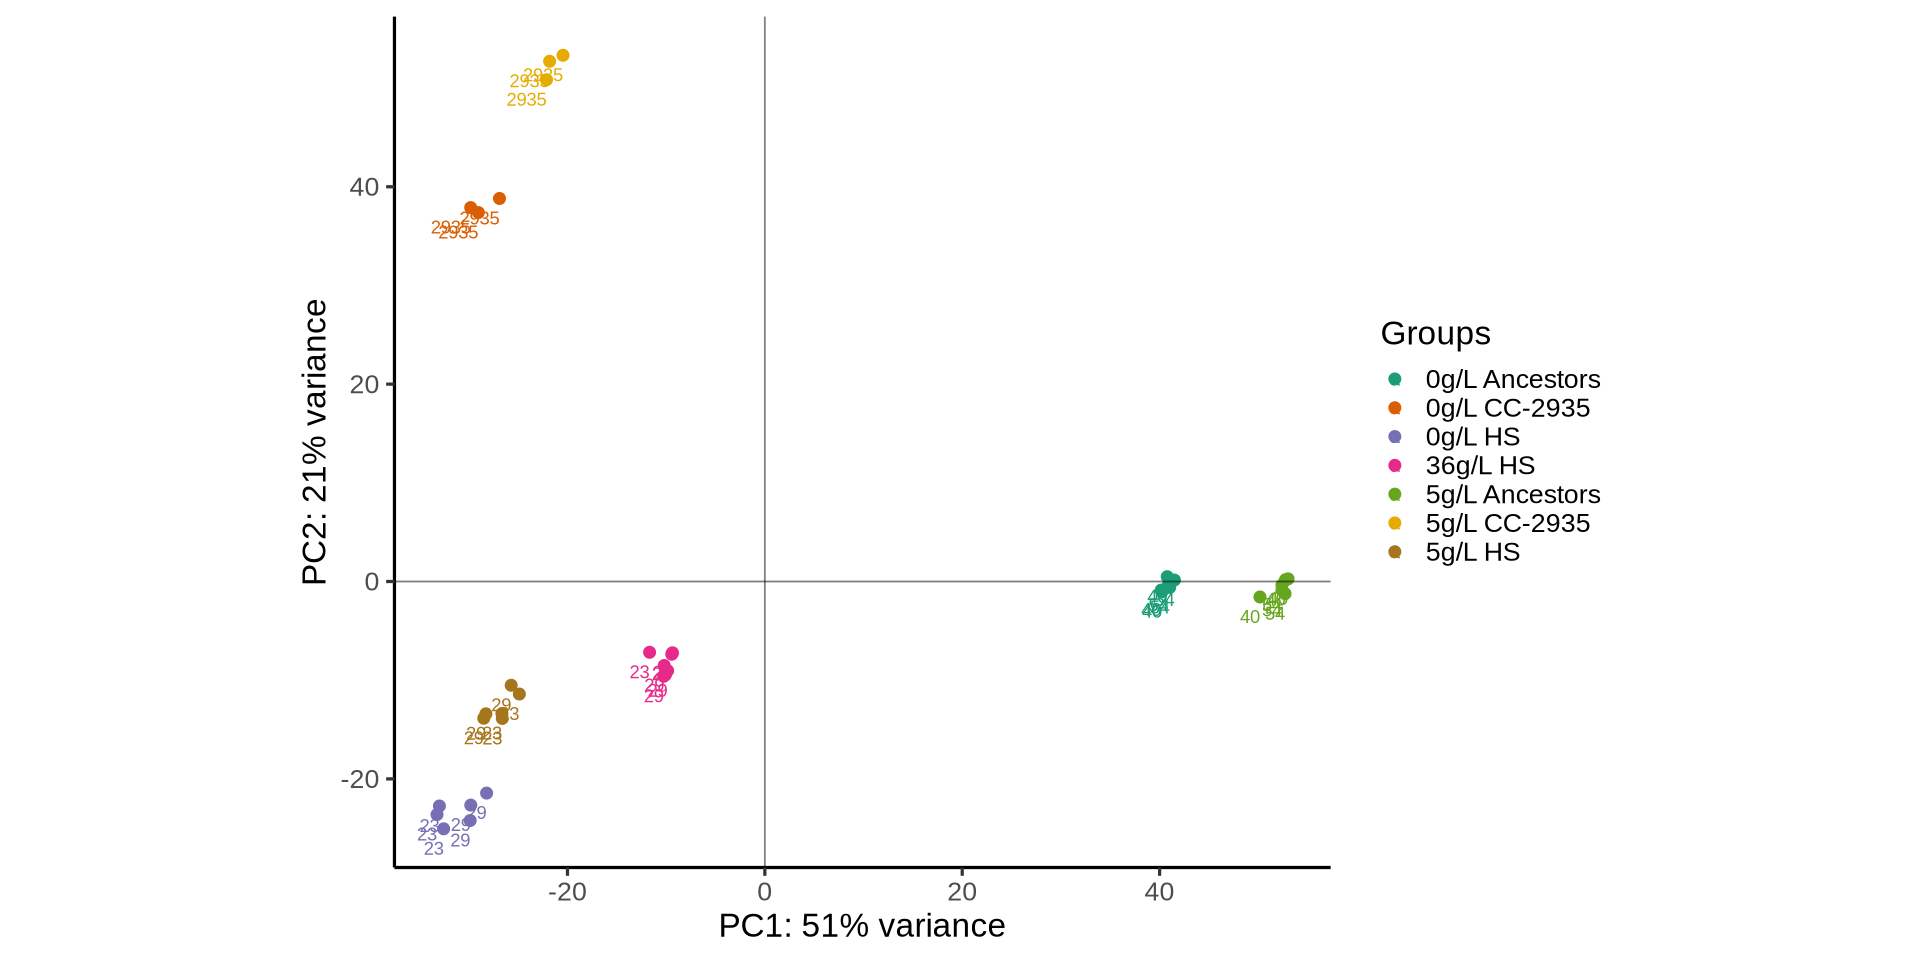

In [11]:
#Transform the data
vsd <- vst(dds, blind = F)

#Visualize samples
plotPCA(vsd, intgroup=c("assay_conc", "selection")) + theme_classic(base_size = 20) + geom_hline(yintercept = 0, alpha = 0.5) + 
    geom_vline(xintercept = 0, alpha = 0.5) + geom_text(aes(label=vsd$sample,hjust=1,vjust=2)) +
    scale_color_manual(values=brewer.pal(n = 7, name = "Dark2"), name="Groups", labels=c("0g/L Ancestors","0g/L CC-2935", "0g/L HS", "36g/L HS", "5g/L Ancestors","5g/L CC-2935", "5g/L HS"))         

# Are responses to shared in Ancestral lines?

In [12]:
# Get the expression change of the progenitors due to salt
Anc <- get_table("groups", "ancestor_5", "ancestor_0")
dim(Anc)

# Get the expression change of CC-2935 due to salt
Par <- get_table("groups", "parent_5", "parent_0")
dim(Par)

[1] 17179     4

[1] 17179     4

In [14]:
#Combine the tables 
AP05 <- merge(Anc, Par, by = 0, suffixes = c("_A", "_P"))

#Clean tables
AP05 <- clean_table(AP05)
head(AP05)
dim(AP05)

,LFC_A,padj_A,DE_A,same_A,LFC_P,padj_P,DE_P,same_P
,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>
CHLRE_01g000017v5,5.19000409,3.582598e-21,TRUE,FALSE,3.0556210,2.428906e-04,TRUE,FALSE
CHLRE_01g000033v5,0.37791629,2.736147e-01,FALSE,TRUE,0.0605580,9.221055e-01,FALSE,TRUE
CHLRE_01g000050v5,-0.02398803,8.956387e-01,FALSE,TRUE,-0.1035296,6.823110e-01,FALSE,TRUE
CHLRE_01g000100v5,-0.04885422,8.158211e-01,FALSE,TRUE,-0.2229061,4.472853e-01,FALSE,TRUE
CHLRE_01g000150v5,0.62066583,1.587786e-01,FALSE,FALSE,3.1748078,9.768954e-08,TRUE,FALSE
CHLRE_01g000200v5,-0.38334057,1.839665e-03,FALSE,FALSE,-0.2394368,2.603515e-01,FALSE,TRUE


[1] 17179     8

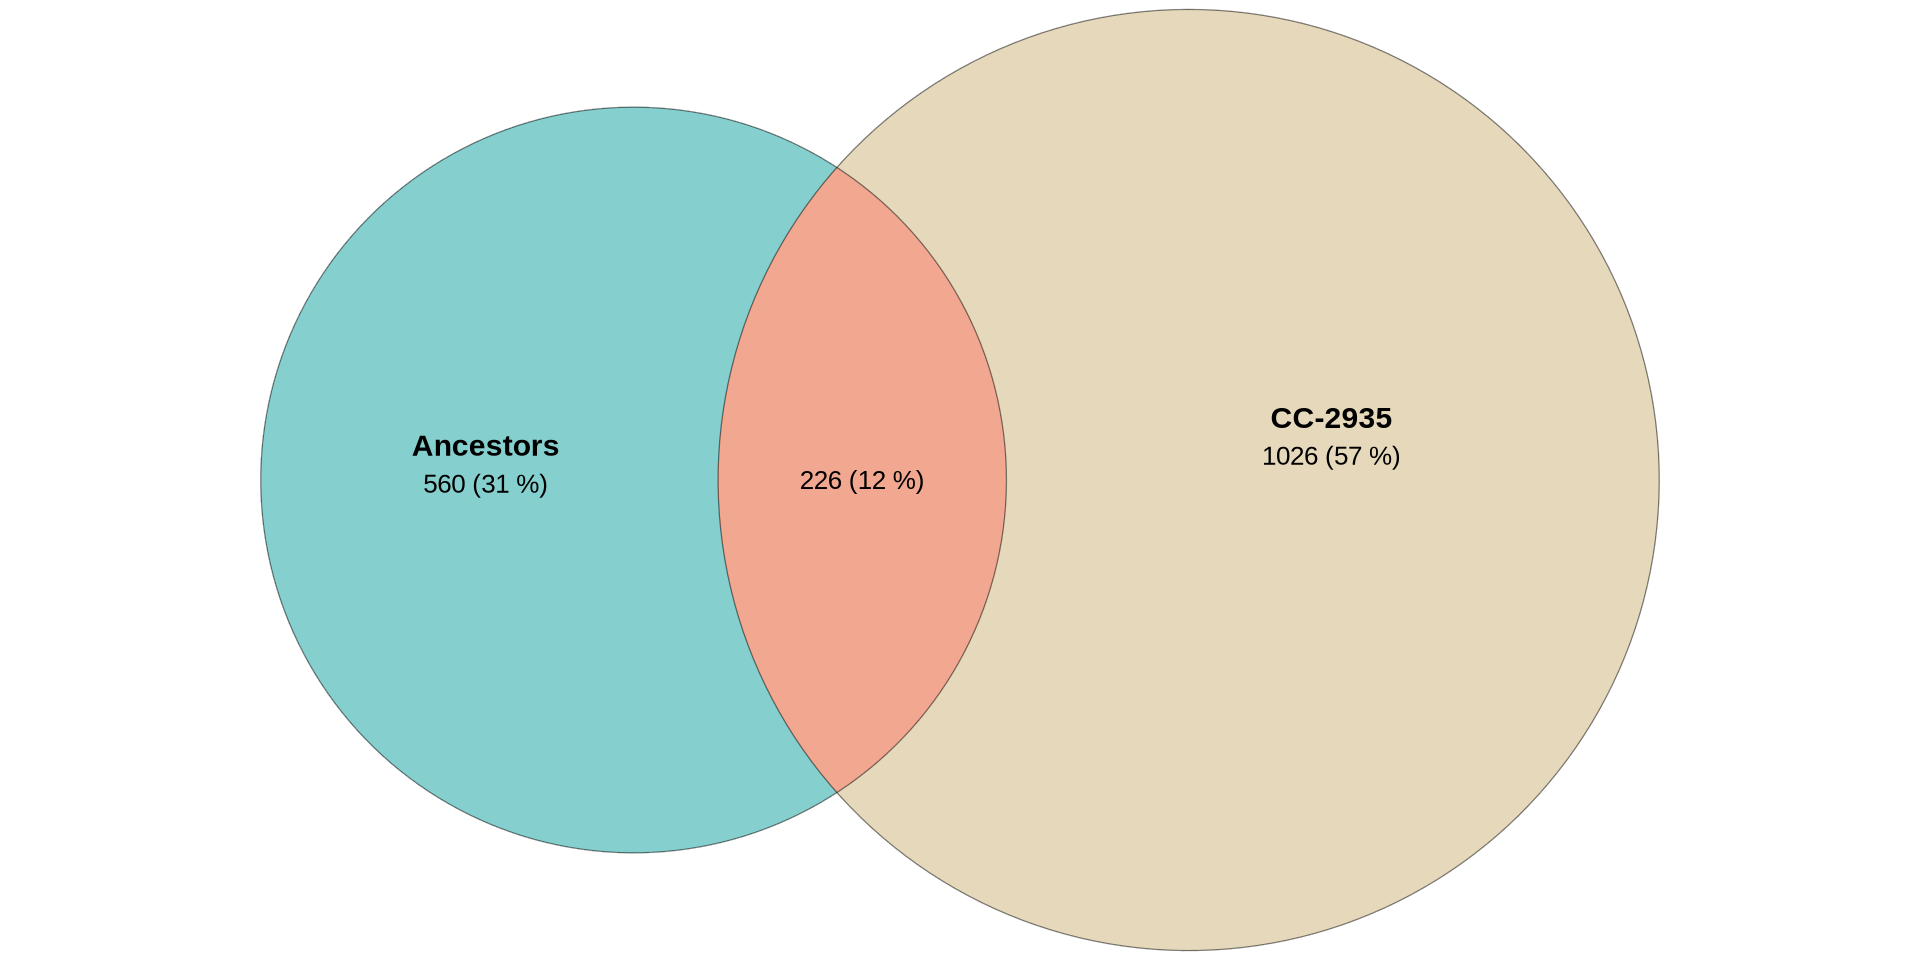

In [15]:
#Visualize shared genes
DEA_genes <- AP05 %>% filter(DE_A == T) %>% rownames()
DEP_genes <- AP05 %>% filter(DE_P == T) %>% rownames()

DEGs_0_5 <- list(Ancestors = DEA_genes, `CC-2935` = DEP_genes)

plot(euler(DEGs_0_5), 
     quantities = list(cex = 1.3, type = c("counts", "percent")),
     labels = list(cex = 1.5), 
    fills =list(fill=wes_palette("AsteroidCity1", 3)), alpha = 0.5)

### Permutations test
Check if the overlap between the Ancestors is greater than expected by chance

# How do the evolved lines react to salt?

In [16]:
# Get the expression change of the HS lines due to 5g/L salt
HS05 <- get_table("groups", "salt_5", "salt_0")
dim(HS05)

[1] 17179     4

## Was the plasticity inherited from ancestral lines?

In [17]:
HSAP05 <- merge(AP05, HS05, by = 0)
HSAP05 <- clean_table(HSAP05)
head(HSAP05)
dim(HSAP05)

,LFC_A,padj_A,DE_A,same_A,LFC_P,padj_P,DE_P,same_P,LFC,padj,DE,same
,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>
CHLRE_01g000017v5,5.19000409,3.582598e-21,TRUE,FALSE,3.0556210,2.428906e-04,TRUE,FALSE,-0.9184300,0.166576092,FALSE,FALSE
CHLRE_01g000033v5,0.37791629,2.736147e-01,FALSE,TRUE,0.0605580,9.221055e-01,FALSE,TRUE,-0.7071187,0.048437693,FALSE,FALSE
CHLRE_01g000050v5,-0.02398803,8.956387e-01,FALSE,TRUE,-0.1035296,6.823110e-01,FALSE,TRUE,0.1663977,0.281685517,FALSE,TRUE
CHLRE_01g000100v5,-0.04885422,8.158211e-01,FALSE,TRUE,-0.2229061,4.472853e-01,FALSE,TRUE,-0.3364148,0.069332396,FALSE,TRUE
CHLRE_01g000150v5,0.62066583,1.587786e-01,FALSE,FALSE,3.1748078,9.768954e-08,TRUE,FALSE,-1.0727842,0.018268799,FALSE,FALSE
CHLRE_01g000200v5,-0.38334057,1.839665e-03,FALSE,FALSE,-0.2394368,2.603515e-01,FALSE,TRUE,-0.3414516,0.005794562,FALSE,FALSE


[1] 17179    12

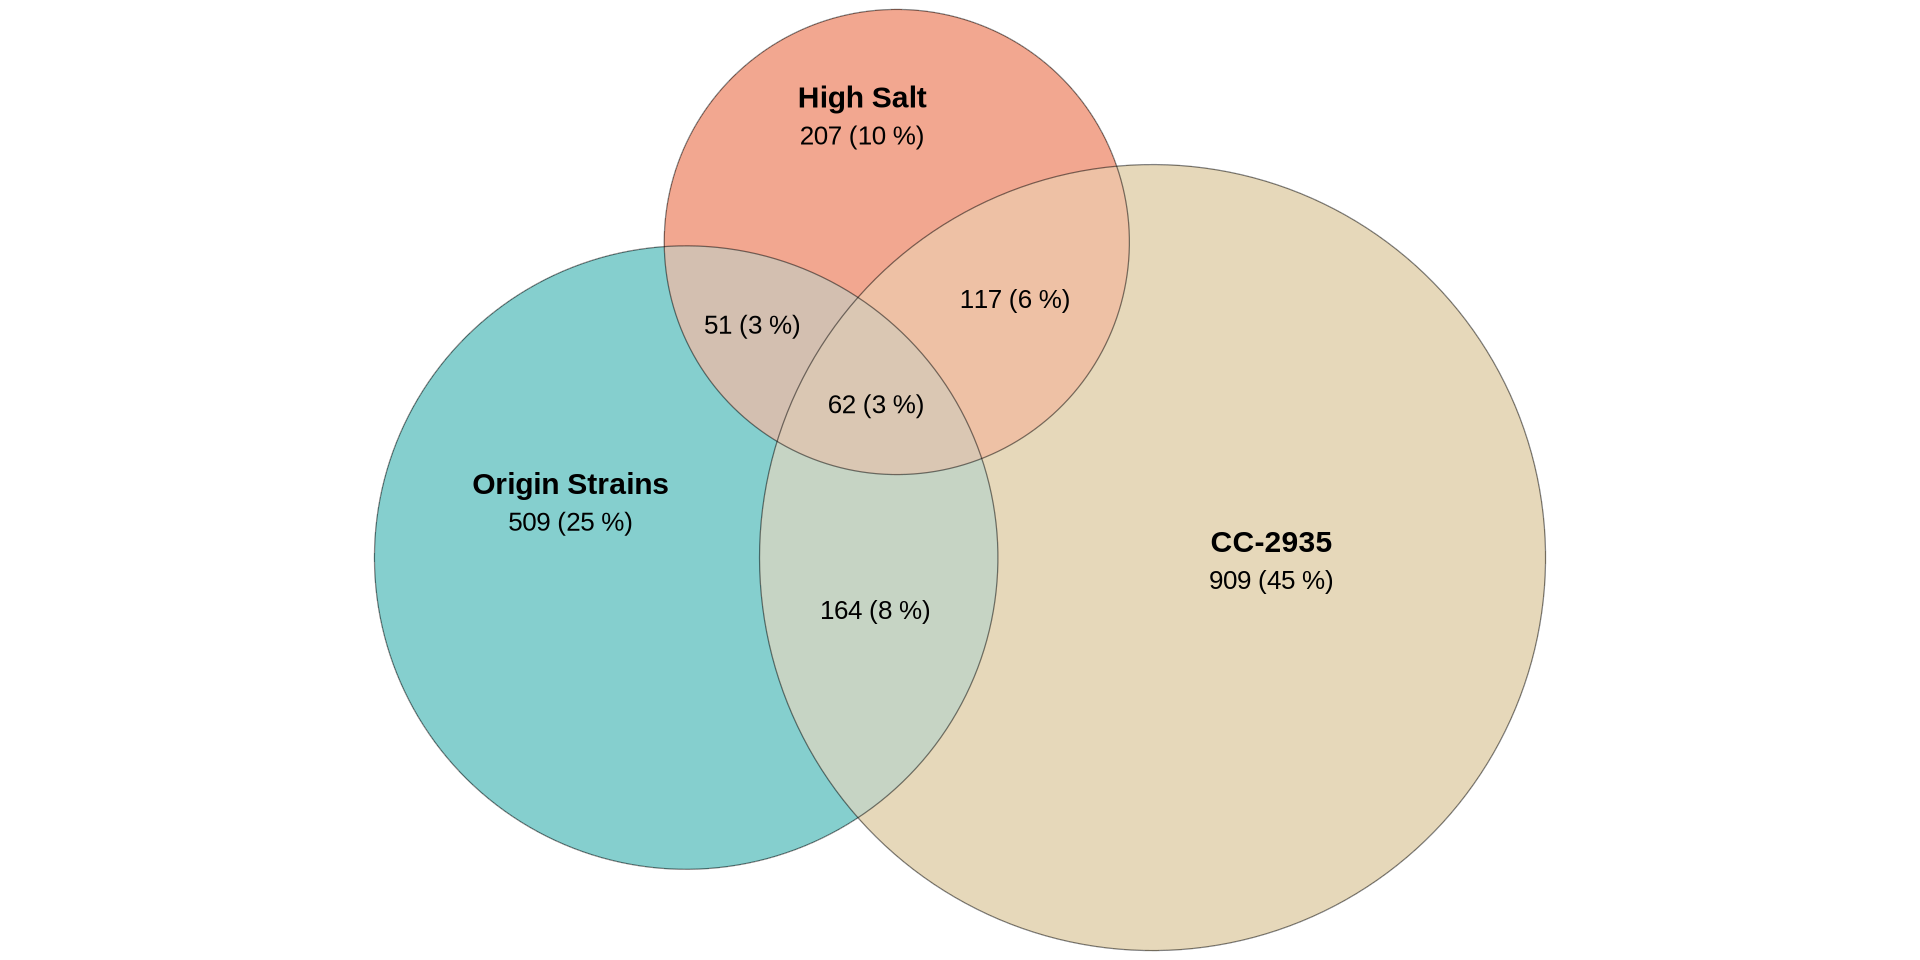

In [18]:
#Visualize the overlap
DEA_genes <- HSAP05 %>% filter(DE_A == T) %>% rownames()
DEP_genes <- HSAP05 %>% filter(DE_P == T) %>% rownames()
DES_genes <- HSAP05 %>% filter(DE == T) %>% rownames()

DEGs_0_5 <- list(`Origin Strains` = DEA_genes, `CC-2935` = DEP_genes, `High Salt` = DES_genes)

plot(euler(DEGs_0_5), 
     quantities = list(cex = 1.3, type = c("counts", "percent")),
     labels = list(cex = 1.5), 
    fills =list(fill=wes_palette("AsteroidCity1", 3)), alpha = 0.5)

### Permutations Progenitors + HS

### Permutations CC-2935 + HS

# Sort into groups of plasticity

In [19]:
# Was it DE in either progenitor lines or CC-2935, then see if it is DE in HS:
HSAP05 <- HSAP05 %>% 
    mutate(DE_AP = DE_A | DE_P, 
           Inherit = case_when(DE_AP == T & DE == T ~ "Inherited Plasticity",
                               DE_AP == F & DE == T ~ "New Plasticity", 
                               DE_AP == T & DE == F ~ "Lost Plasticity",
                              .default = "Constitutive"))
table(HSAP05$Inherit)


        Constitutive Inherited Plasticity      Lost Plasticity 
               15160                  230                 1582 
      New Plasticity 
                 207 

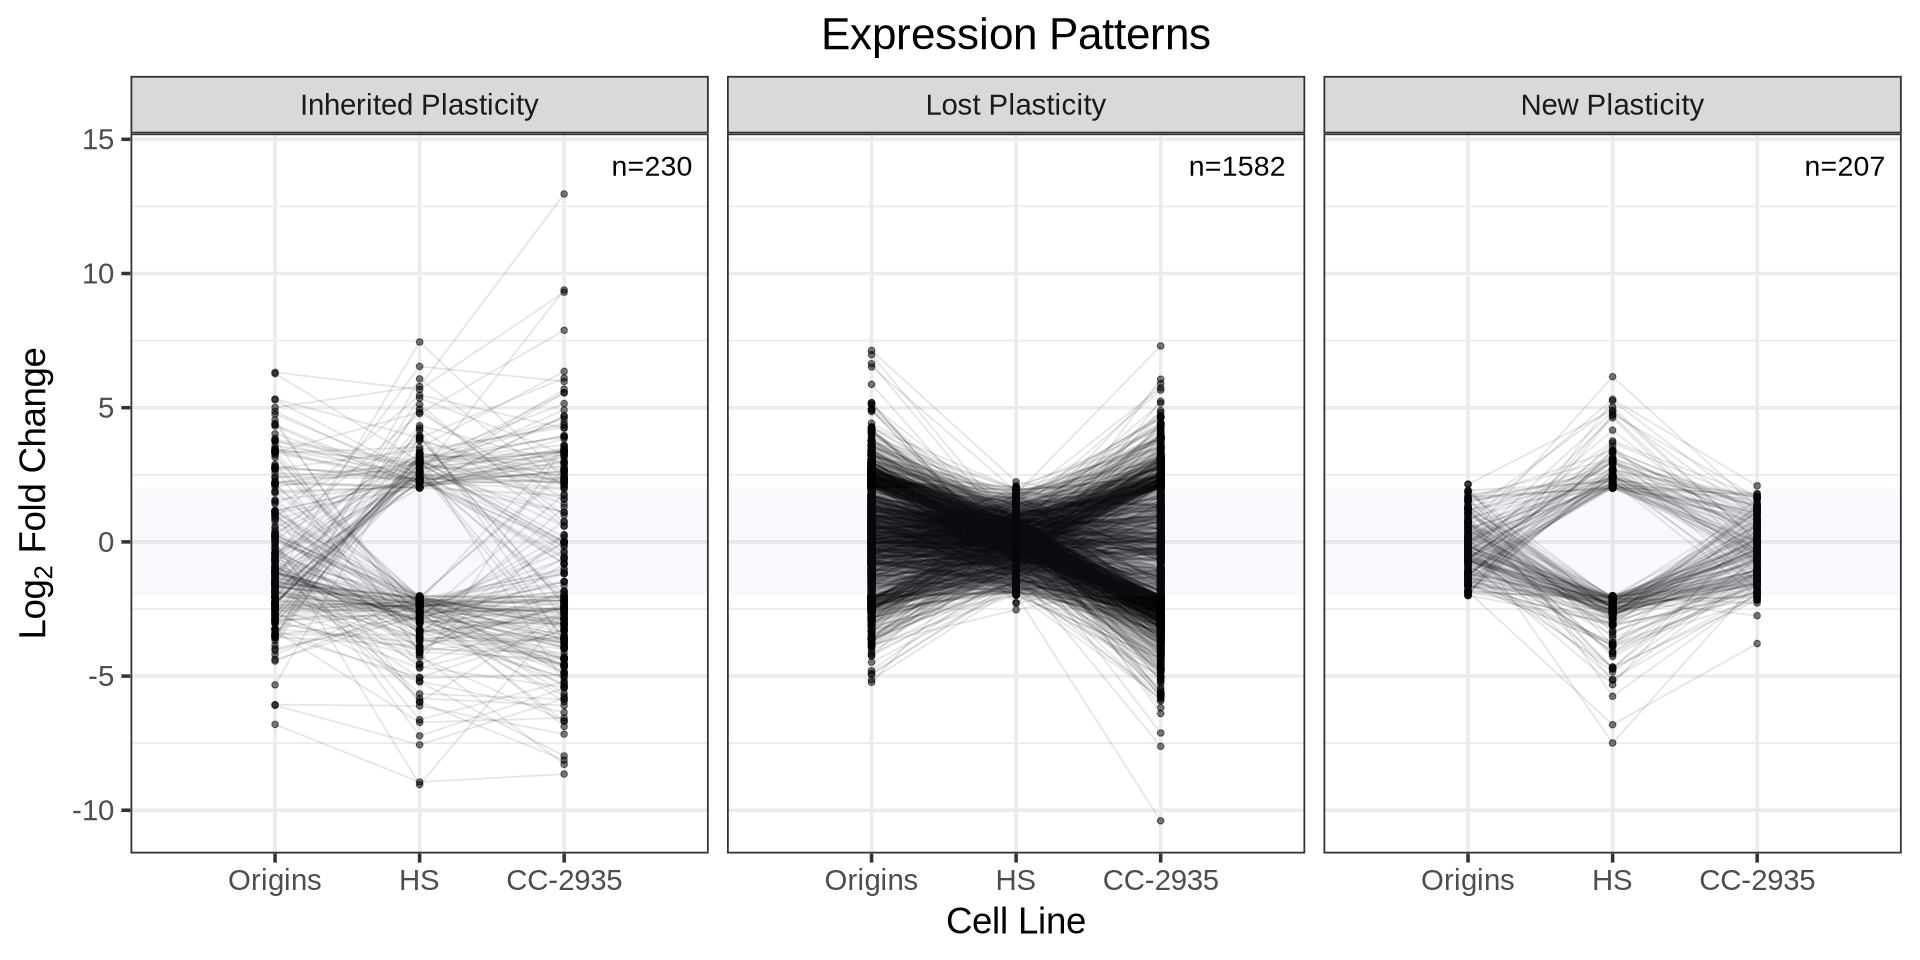

In [20]:
#Visualize the expression patterns
line_names <- c("A" = "Origins", "LFC" = "HS", "P" = "CC-2935")
pattern_p_numbers <- data.frame(table(HSAP05$Inherit))
colnames(pattern_p_numbers) <- c("Inherit", "label")
pattern_p_numbers <- pattern_p_numbers %>% filter(Inherit != "Constitutive")

pattern_p <- HSAP05 %>% 
    mutate(Genes = rownames(.)) %>%
    select(contains("LFC"), "Inherit", "Genes") %>%
    filter(Inherit != "Constitutive") %>%
    pivot_longer(c(LFC_A, LFC_P, LFC), names_to = "Line", values_to = "LFC") %>%
    mutate(Line = gsub(pattern = "LFC_", replacement = "", Line)) %>%
    ggplot(aes(x = Line, y = LFC, group = Genes))+
        geom_point(alpha = 0.5)+
        geom_line(alpha = 0.1) +
        facet_grid(~Inherit) +
        theme_bw(base_size = 22) +
        theme(plot.title = element_text(hjust = 0.5)) +
        annotate("rect", xmin = 0, xmax = 4, ymin = -2, ymax = 2, alpha = 0.05, fill= "#6699CC")+
        scale_x_discrete(labels = line_names)+
        labs(x = "Cell Line", y = expression("Log"["2"] ~ "Fold Change"), title = "Expression Patterns")

pattern_p + geom_text(
  size    = 6,
  data    = pattern_p_numbers,
  mapping = aes(x = Inf, y = 14, label = paste0("n=",label), group=NULL),
  hjust   = 1.2,
  vjust   = 0.5
)

In [21]:
#Break down into more detailed categories
HSAP05 <- HSAP05 %>% mutate(Inherit = case_when(Inherit == "Inherited Plasticity" & (DE_P == T & DE_A == T) ~ "Inherited Origins & CC-2935 Plasticity",
                                                Inherit == "Inherited Plasticity" & DE_A == T ~ "Inherited Origins Plasticity", 
                                                Inherit == "Inherited Plasticity" & DE_P == T ~ "Inherited CC-2935 Plasticity",
                                                Inherit == "Lost Plasticity" & (DE_P == T & DE_A == T) ~ "Lost Origins & CC-2935 Plasticity",
                                                Inherit == "Lost Plasticity" & DE_A == T ~ "Lost Origins Plasticity", 
                                                Inherit == "Lost Plasticity" & DE_P == T ~ "Lost CC-2935 Plasticity",
                                                .default = Inherit), 
                           Genes = rownames(.))
table(HSAP05$Inherit)


                          Constitutive           Inherited CC-2935 Plasticity 
                                 15160                                    117 
Inherited Origins & CC-2935 Plasticity           Inherited Origins Plasticity 
                                    62                                     51 
               Lost CC-2935 Plasticity      Lost Origins & CC-2935 Plasticity 
                                   909                                    164 
               Lost Origins Plasticity                         New Plasticity 
                                   509                                    207 

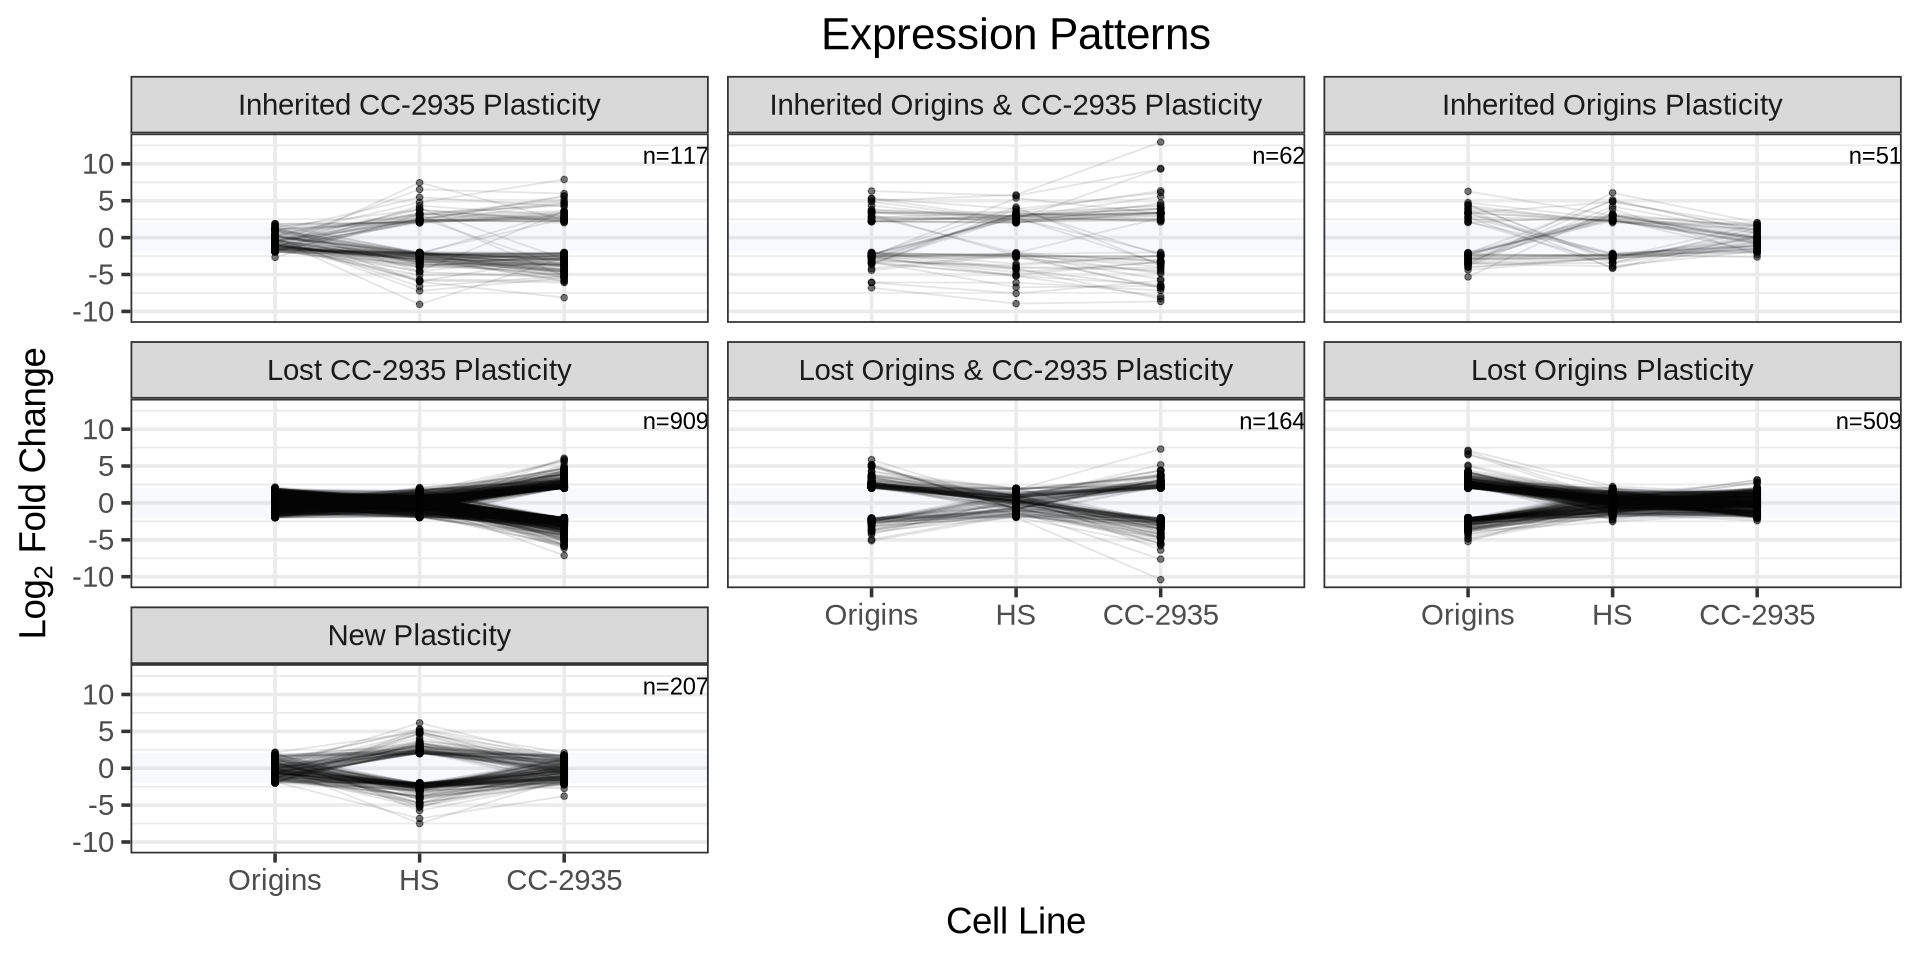

In [22]:
#Visualize the more detailed expression patterns
pattern_p_numbers <- data.frame(table(HSAP05$Inherit))
colnames(pattern_p_numbers) <- c("Inherit", "label")
pattern_p_numbers <- pattern_p_numbers %>% filter(Inherit != "Constitutive")

pattern_p <- HSAP05 %>% 
    select(contains("LFC"), "Inherit", "Genes") %>%
    filter(Inherit != "Constitutive") %>%
    pivot_longer(c(LFC_A, LFC_P, LFC), names_to = "Line", values_to = "LFC") %>%
    mutate(Line = gsub(pattern = "LFC_", replacement = "", Line)) %>%
    ggplot(aes(x = Line, y = LFC, group = Genes))+
        annotate("rect", xmin = 0, xmax = 4, ymin = -2, ymax = 2, alpha = 0.05, fill= "#6699CC")+
        geom_point(alpha = 0.5)+
        geom_line(alpha = 0.1) +
        facet_wrap(~Inherit, ncol = 3) +
        theme_bw(base_size = 22) +
        theme(plot.title = element_text(hjust = 0.5)) +
        scale_x_discrete(labels = line_names)+
        labs(x = "Cell Line", y = expression("Log"["2"] ~ "Fold Change"), title = "Expression Patterns")

pattern_p + geom_text(
  size    = 5,
  data    = pattern_p_numbers,
  mapping = aes(x = Inf, y = 10, label = paste0("n=",label), group=NULL),
  hjust   = 1,
  vjust   = 0
)

# WGCNA
## Get Counts

In [25]:
# Get VST For samples
normalized_counts <- vst(dds, blind = F) %>%
                        assay() %>%
                        t() %>%
                        data.frame()

head(normalized_counts)

,CHLRE_01g000017v5,CHLRE_01g000033v5,CHLRE_01g000050v5,CHLRE_01g000100v5,CHLRE_01g000150v5,CHLRE_01g000200v5,CHLRE_01g000250v5,CHLRE_01g000300v5,CHLRE_01g000350v5,CHLRE_01g000400v5,⋯,CHLRE_48g761197v5,CHLRE_48g761247v5,CHLRE_49g761297v5,CHLRE_49g761347v5,CHLRE_50g761397v5,CHLRE_50g761447v5,CHLRE_50g761497v5,CHLRE_51g761547v5,CHLRE_51g761597v5,CHLRE_52g761647v5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23_00_1,13.48420,5.943712,8.398448,7.777752,7.390162,8.611747,7.900548,10.016315,9.358371,7.522408,⋯,10.83087,4.456242,4.456242,7.618330,6.718339,7.708206,9.485684,5.621521,5.330312,4.292927
23_00_2,13.54754,6.417901,8.416470,8.140298,7.114679,8.681408,8.367147,10.378233,9.696403,7.392692,⋯,11.35127,4.550170,4.275167,6.665909,6.284646,7.554434,9.742771,5.069273,5.011890,4.431349
23_00_3,12.34066,6.898479,8.423745,8.495424,7.445639,8.791738,8.263854,10.127096,9.575206,7.479484,⋯,11.34746,4.644244,4.545575,8.483032,6.793710,8.168974,9.565456,6.167069,6.123262,4.644244
23_05_1,12.22567,6.325423,8.757955,8.285918,6.942663,8.111381,7.921125,9.661575,9.060049,8.019407,⋯,11.54504,6.079384,5.081110,8.423716,7.561563,8.321627,9.118346,6.229555,6.533332,4.961510
23_05_2,11.86334,6.471687,8.716800,8.208417,6.350547,8.258366,8.337936,10.105795,9.216763,7.457293,⋯,12.07249,5.857407,5.313723,8.671486,6.995745,8.216863,9.286502,6.781643,6.871257,4.800655
23_05_3,11.88867,6.401243,8.363696,7.909216,6.503131,8.288538,8.521645,10.522753,9.572868,6.970606,⋯,12.30375,5.385562,4.692798,8.437902,7.061068,8.254181,9.359223,6.556613,6.341150,4.325024


## Visualize thresholds 

In [27]:
sft <- pickSoftThreshold(normalized_counts,
  dataIsExpr = TRUE,
  corFnc = cor #default net type is unsigned (neg is considered)
)
sft_df <- data.frame(sft$fitIndices) %>%
  dplyr::mutate(model_fit = -sign(slope) * SFT.R.sq)

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.79500  3.8600          0.979  5760.0   5900.00   7730
2      2  0.41300  1.1000          0.929  2750.0   2800.00   4680
3      3  0.00242  0.0545          0.872  1540.0   1530.00   3210
4      4  0.20200 -0.5170          0.902   954.0    911.00   2370
5      5  0.44800 -0.8540          0.950   630.0    574.00   1830
6      6  0.59800 -1.1000          0.971   436.0    378.00   1460
7      7  0.69000 -1.2800          0.984   313.0    258.00   1200
8      8  0.75100 -1.4000          0.989   232.0    181.00   1010
9      9  0.79200 -1.5000          0.994   176.0    129.00    857
10    10  0.82600 -1.5800          0.996   136.0     94.60    740
11    12  0.87200 -1.6600          0.996    85.9     52.90    569
12    14  0.89700 -1.7400          0.996    57.1     31.00    460
13    16  0.91500 -1.7800          0.993    39.6     19.10    381
14    18  0.92600 -1.8000          0.992    28.4     12.10    323
15    20  

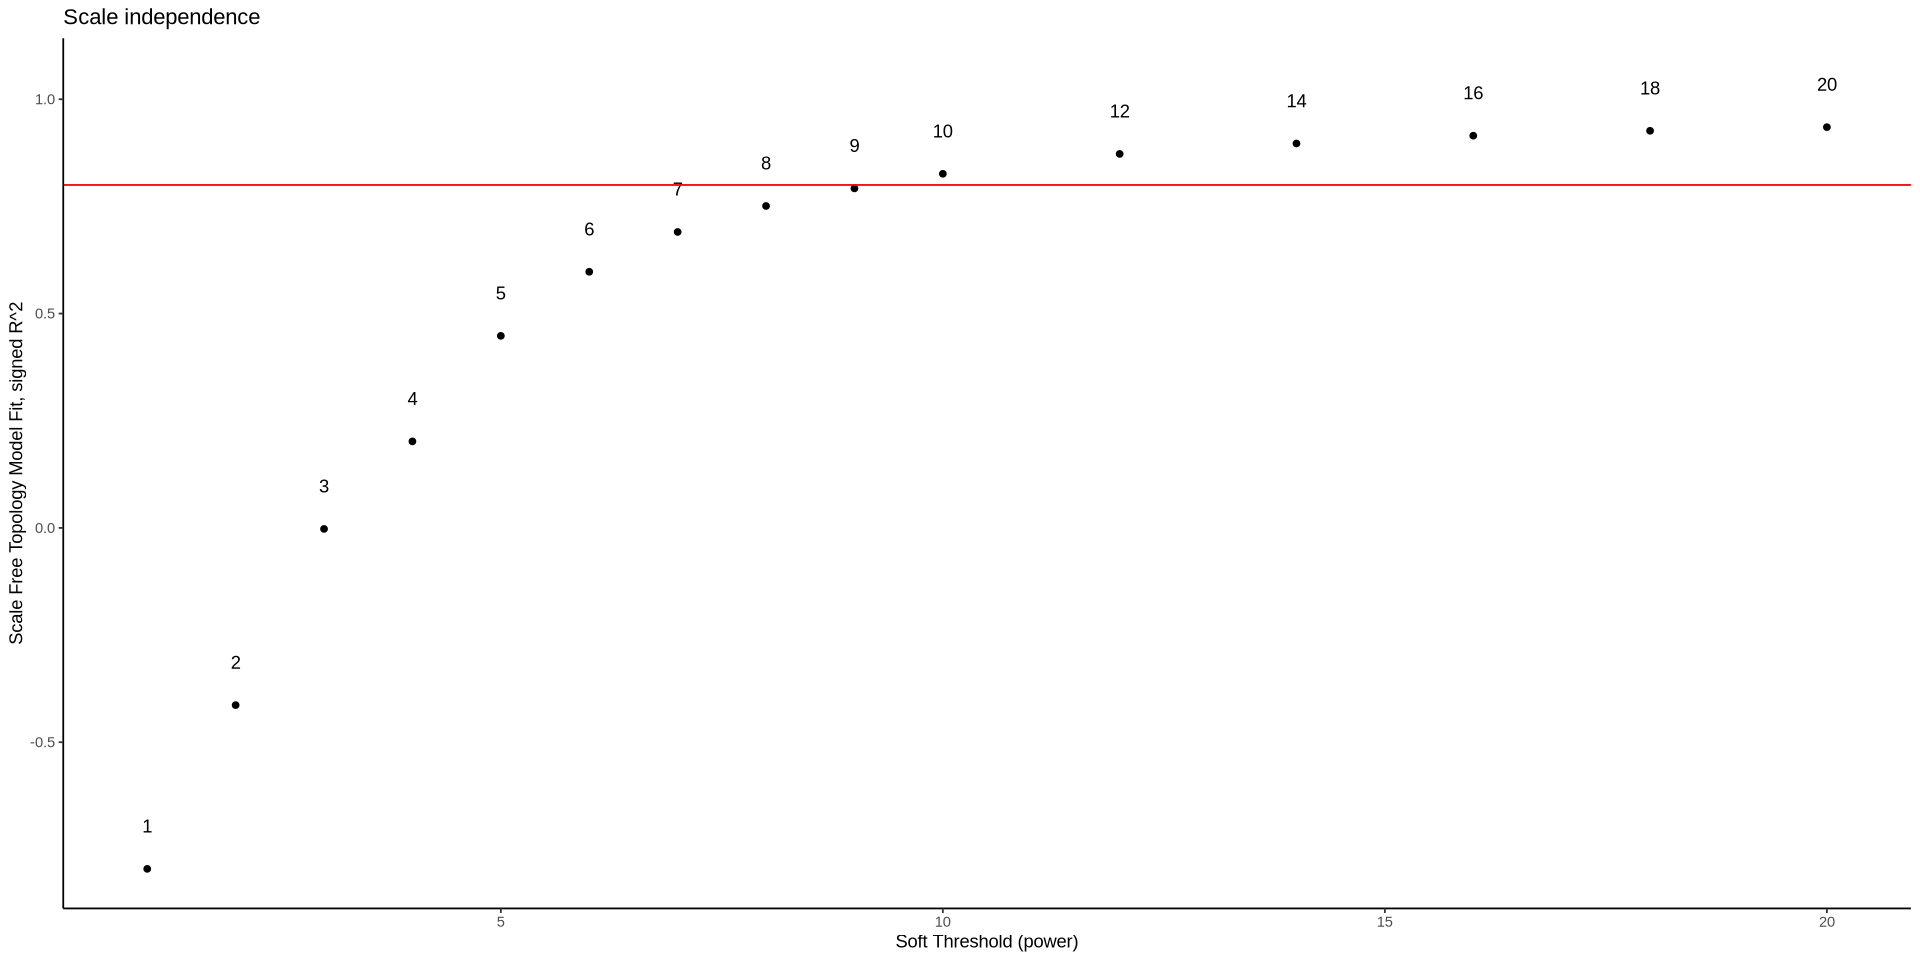

In [28]:
ggplot(sft_df, aes(x = Power, y = model_fit, label = Power)) +
  geom_point() +
  geom_text(nudge_y = 0.1) +
  geom_hline(yintercept = 0.80, col = "red") +
  ylim(c(min(sft_df$model_fit), 1.05)) +
  xlab("Soft Threshold (power)") +
  ylab("Scale Free Topology Model Fit, signed R^2") +
  ggtitle("Scale independence") +
  theme_classic()

## Build Network

In [30]:
genes_to_mods <- data.frame(genes = names(normalized_counts))
cor <- WGCNA::cor #specify the correlation from WGCNA
cor_cuttoff <- 0.8
net = blockwiseModules(normalized_counts, power = 7, loadTOM = TRUE,
                       TOMType = "unsigned", maxBlockSize = 18000, mergeCutHeight = (1-cor_cuttoff), reassignThreshold = 0,
                       numericLabels = FALSE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE, saveTOMFileBase = "adaptive_plasticity_TOM",
                       verbose = 2, randomSeed = 2502)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file 'adaptive_plasticity_TOM-block.1.RData', probable reason 'No such file or directory'”


Loading of TOM in block 1 failed:
 file adaptive_plasticity_TOM-block.1.RData
  either does not exist or does not contain the object 'TOM'.
  Will recalculate TOM.
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..merging modules that are too close..


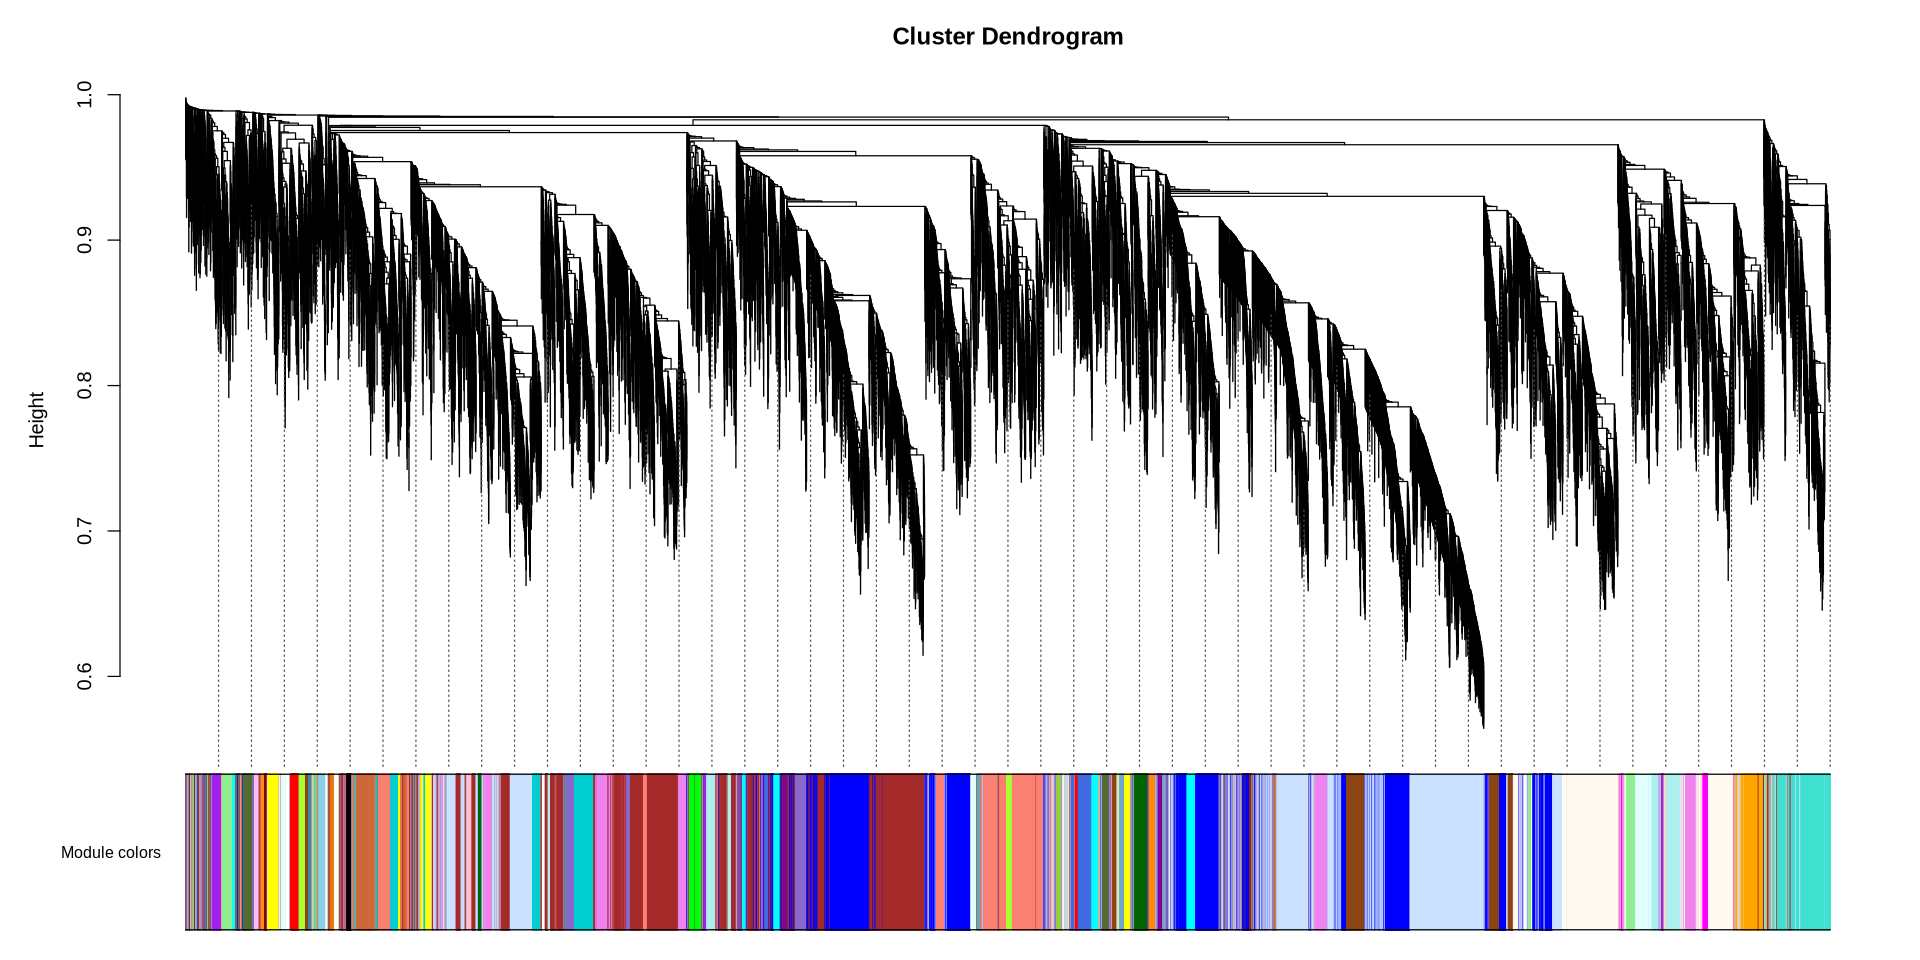

In [31]:
#Visualize Spread
mergedColors = labels2colors(net$colors)
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]], "Module colors",
                    dendroLabels = FALSE,addGuide = TRUE, guideHang = 0.05)

In [32]:
#Export data from network
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]]

## Match to trait data

In [33]:
#Get reference data and clean dataframe
traitData = read.csv("../Reference_Files/Network_Analysis/ClinicalTraitsBinary.csv")
traitData$Samples <- gsub(traitData$Samples, pattern = "X", replacement = "")
rownames(traitData) <- traitData$Samples
head(traitData)

#Select relevent columns of sample data
traitData <- traitData %>% select(Samples, X40, X54, Ancestor, X2935, Evolved, X23, X29, Conc.0, Conc.5, Conc.36)

Samples <- rownames(normalized_counts)
traitRows <- match(Samples, traitData$Samples)
datTraits <- traitData[traitRows, -1]
rownames(datTraits) <- traitData[traitRows, 1]
head(datTraits) # put the sample names in binary file in the same order as the normalized counts
head(normalized_counts)

,Samples,Conc.0,Conc.5,Conc.36,Evolved,Ancestor,X29,X23,X2935,X40,X54
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
23_00_1,23_00_1,1,0,0,1,0,0,1,0,0,0
23_00_2,23_00_2,1,0,0,1,0,0,1,0,0,0
23_00_3,23_00_3,1,0,0,1,0,0,1,0,0,0
29_00_1,29_00_1,1,0,0,1,0,1,0,0,0,0
29_00_2,29_00_2,1,0,0,1,0,1,0,0,0,0
29_00_3,29_00_3,1,0,0,1,0,1,0,0,0,0


,X40,X54,Ancestor,X2935,Evolved,X23,X29,Conc.0,Conc.5,Conc.36
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
23_00_1,0,0,0,0,1,1,0,1,0,0
23_00_2,0,0,0,0,1,1,0,1,0,0
23_00_3,0,0,0,0,1,1,0,1,0,0
23_05_1,0,0,0,0,1,1,0,0,1,0
23_05_2,0,0,0,0,1,1,0,0,1,0
23_05_3,0,0,0,0,1,1,0,0,1,0


,CHLRE_01g000017v5,CHLRE_01g000033v5,CHLRE_01g000050v5,CHLRE_01g000100v5,CHLRE_01g000150v5,CHLRE_01g000200v5,CHLRE_01g000250v5,CHLRE_01g000300v5,CHLRE_01g000350v5,CHLRE_01g000400v5,⋯,CHLRE_48g761197v5,CHLRE_48g761247v5,CHLRE_49g761297v5,CHLRE_49g761347v5,CHLRE_50g761397v5,CHLRE_50g761447v5,CHLRE_50g761497v5,CHLRE_51g761547v5,CHLRE_51g761597v5,CHLRE_52g761647v5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23_00_1,13.48420,5.943712,8.398448,7.777752,7.390162,8.611747,7.900548,10.016315,9.358371,7.522408,⋯,10.83087,4.456242,4.456242,7.618330,6.718339,7.708206,9.485684,5.621521,5.330312,4.292927
23_00_2,13.54754,6.417901,8.416470,8.140298,7.114679,8.681408,8.367147,10.378233,9.696403,7.392692,⋯,11.35127,4.550170,4.275167,6.665909,6.284646,7.554434,9.742771,5.069273,5.011890,4.431349
23_00_3,12.34066,6.898479,8.423745,8.495424,7.445639,8.791738,8.263854,10.127096,9.575206,7.479484,⋯,11.34746,4.644244,4.545575,8.483032,6.793710,8.168974,9.565456,6.167069,6.123262,4.644244
23_05_1,12.22567,6.325423,8.757955,8.285918,6.942663,8.111381,7.921125,9.661575,9.060049,8.019407,⋯,11.54504,6.079384,5.081110,8.423716,7.561563,8.321627,9.118346,6.229555,6.533332,4.961510
23_05_2,11.86334,6.471687,8.716800,8.208417,6.350547,8.258366,8.337936,10.105795,9.216763,7.457293,⋯,12.07249,5.857407,5.313723,8.671486,6.995745,8.216863,9.286502,6.781643,6.871257,4.800655
23_05_3,11.88867,6.401243,8.363696,7.909216,6.503131,8.288538,8.521645,10.522753,9.572868,6.970606,⋯,12.30375,5.385562,4.692798,8.437902,7.061068,8.254181,9.359223,6.556613,6.341150,4.325024


## Create a correlation matrix

In [34]:
nGenes = ncol(normalized_counts)
nSamples = nrow(normalized_counts)

null device 
          1

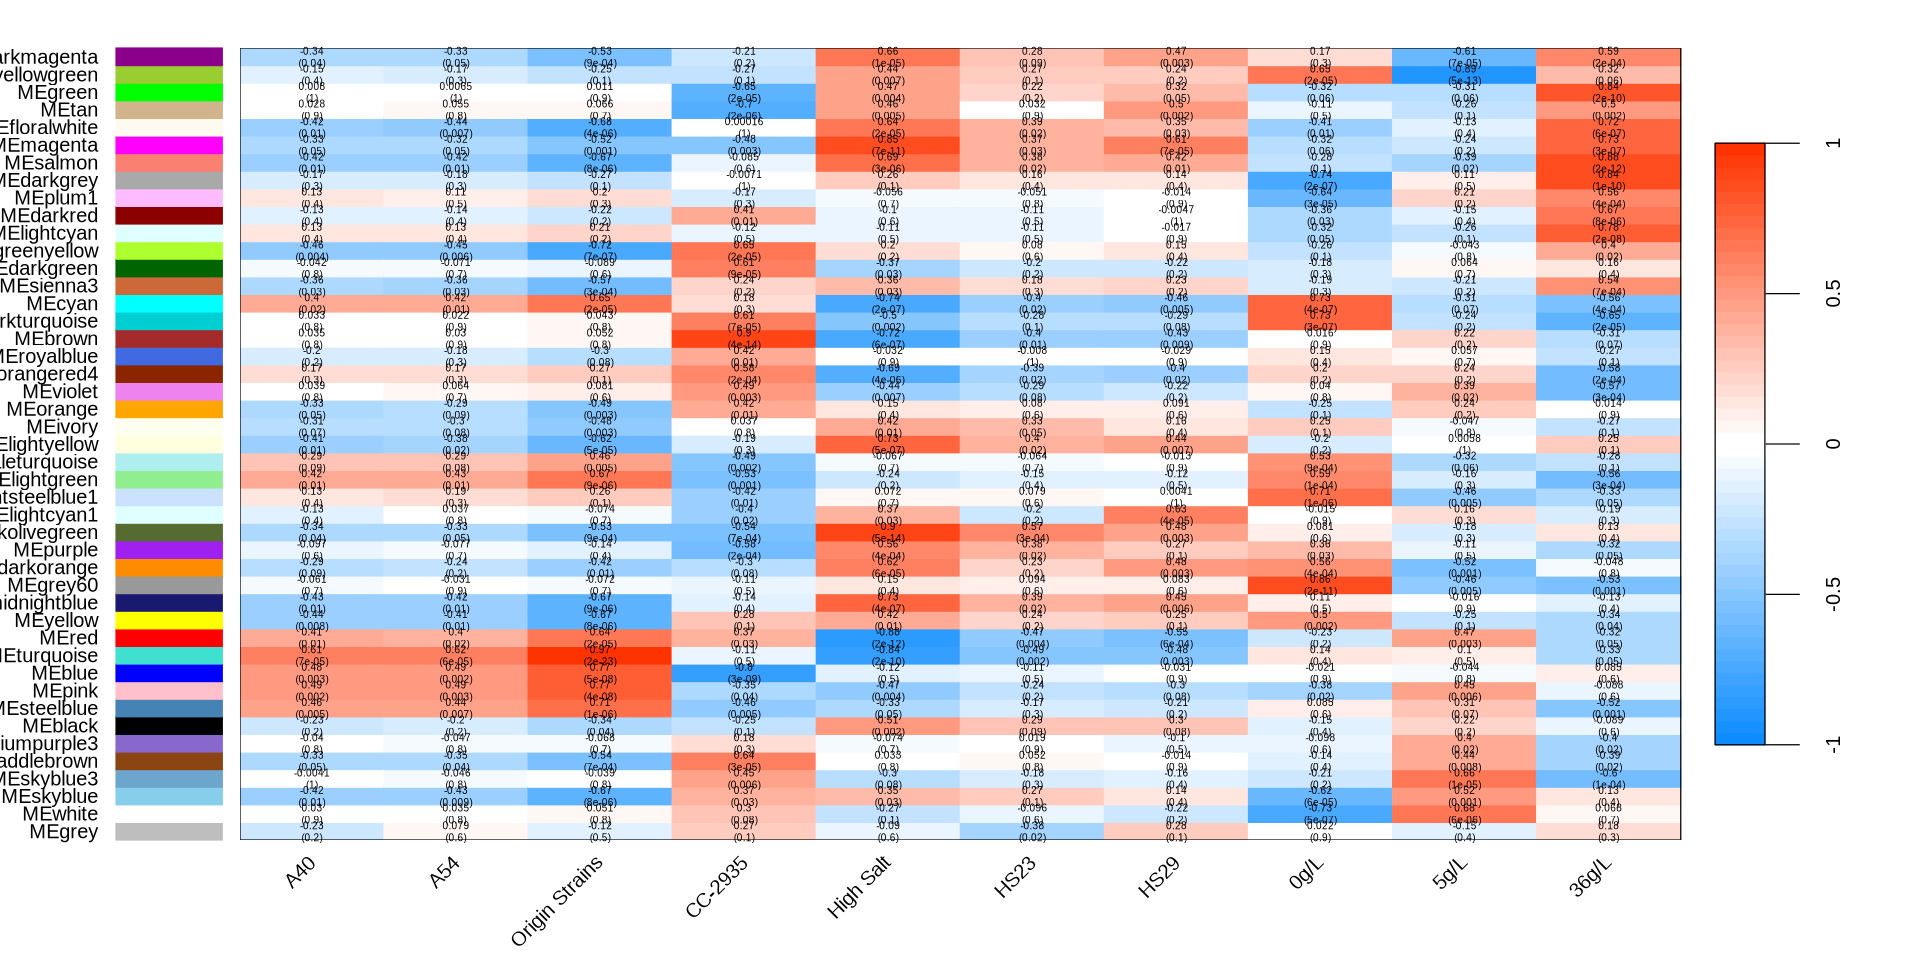

In [35]:
#Create the full heatmap
module.trait.correlation = cor(MEs, datTraits, use = "p") #p for pearson correlation coefficient 
module.trait.Pvalue = corPvalueStudent(module.trait.correlation, nSamples) #calculate the p-value associated with the correlation
textMatrix = paste(signif(module.trait.correlation, 2), "\n(",signif(module.trait.Pvalue, 1), ")", sep = "")
dim(textMatrix) = dim(module.trait.correlation)

# options(repr.plot.width=8, repr.plot.height=8)
# jpeg("WGCNA_Heatmap.jpeg", width=8, height=10, units="in", res=600)
par(mar=c(5, 10, 2, 2)) 
labeledHeatmap(Matrix = module.trait.correlation,
             xLabels = c("A40", "A54", "Origin Strains", "CC-2935", "High Salt", "HS23", "HS29", "0g/L", "5g/L", "36g/L"),
             yLabels = rownames(module.trait.correlation),
             ySymbols = rownames(module.trait.correlation),
             colorLabels = FALSE,
             colors = blueWhiteRed(50),
             textMatrix = textMatrix,
             setStdMargins = FALSE,
             cex.text = .5,
             zlim = c(-1,1))
dev.off()

[1] "MEyellowgreen"    "MEgreen"          "MEmagenta"        "MEsalmon"        
 [5] "MEdarkgrey"       "MEbrown"          "MEdarkolivegreen" "MEgrey60"        
 [9] "MEred"            "MEturquoise"      "MEblue"

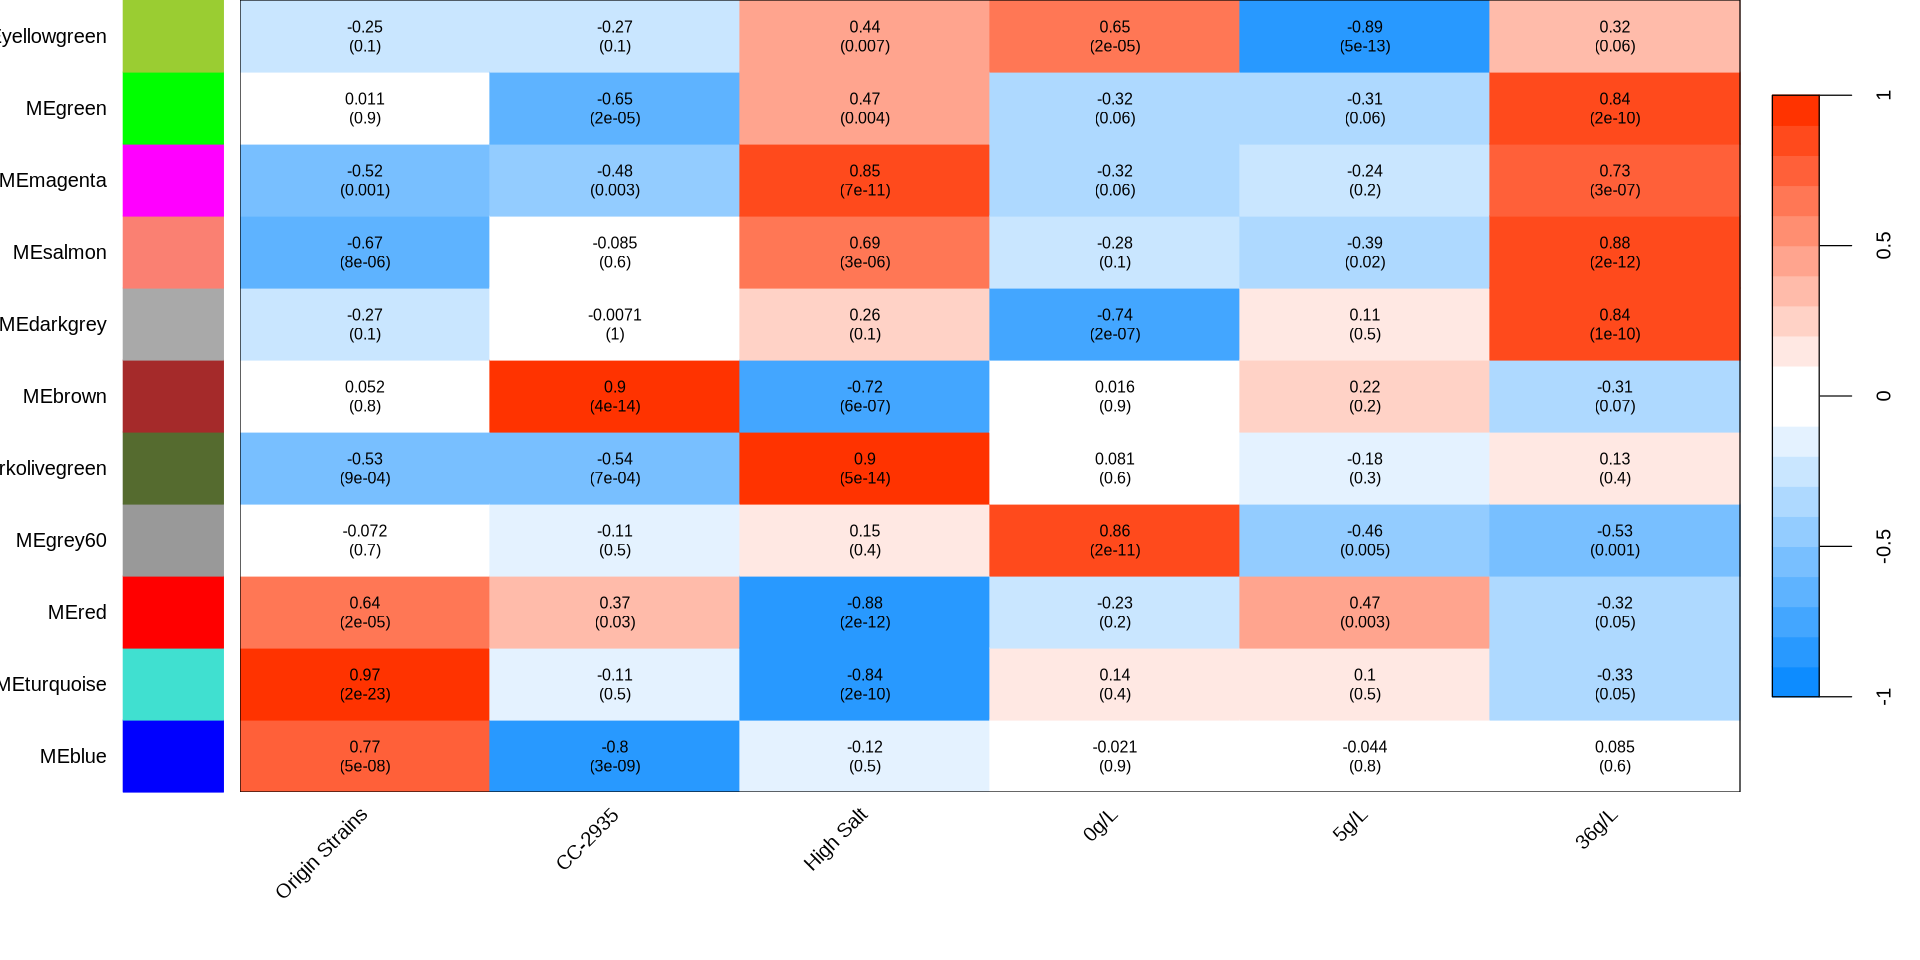

In [38]:
#Create matrix for modules of interest

# find modules of interest that meet correlation threshold
mods_of_interest <- module.trait.correlation %>% data.frame() %>% select(Ancestor, X2935, Evolved, `Conc.0`,`Conc.5`,`Conc.36`) %>% 
                    filter(abs(Ancestor) > 0.8 |abs(X2935) > 0.8 | abs(Evolved) > 0.8 | abs(`Conc.0`) > 0.8 | abs(`Conc.5`) > 0.8 | abs(`Conc.36`) > 0.8) %>% 
                    rownames() 
mods_of_interest

# filter
textMatrix_interest <- textMatrix[rownames(module.trait.correlation) %in% mods_of_interest,-c(1,2,6,7)]
module.trait.correlation_interest <- data.frame(module.trait.correlation) %>% filter(rownames(.) %in% mods_of_interest) %>% select(-c("X40", "X54", "X23", "X29"))
par(mar=c(7, 10, 0, 0)) 
labeledHeatmap(Matrix = module.trait.correlation_interest,
             xLabels = c("Origin Strains", "CC-2935", "High Salt", "0g/L", "5g/L", "36g/L"),
             yLabels = rownames(module.trait.correlation_interest),
             ySymbols = rownames(module.trait.correlation_interest),
             colorLabels = FALSE,
             colors = blueWhiteRed(20),
             textMatrix = textMatrix_interest,
             setStdMargins = FALSE,
             cex.text = .8,
             zlim = c(-1,1))


## Get Hubs

In [39]:
#Create dataframe
wgcna_mods <- data.frame(genes = names(normalized_counts), module = moduleColors, hub = F)

### Intermodule

In [40]:
counter = 0
probes = names(normalized_counts) #genes
hubs = rep(NA,length(modules))
names(hubs) = modules
for (m in modules){
    inModule = (moduleColors==m) #filter the genes in that module
    modProbes = probes[inModule] #get the genes in that module
    nTop = round(length(modProbes) * 0.05) #calculate 5% of the number of genes in the module
    temp <- normalized_counts[, modProbes] #get the counts for that gene
    IMConn = softConnectivity(temp) #calculate connectivity
    top = (rank(-IMConn) <= nTop) #TF df
    greater_avg <- IMConn >= mean(IMConn, na.rm = T) #TF df to see the genes with higher connectivity than average
    hubs[m] = list(names(temp)[greater_avg | top])
    wgcna_mods$hub <- ifelse(wgcna_mods$genes %in% names(temp)[greater_avg | top], yes = T, no = wgcna_mods$hub)
}

 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less

### Whole Network

In [41]:
#Calculate full network connectivity
IMConn_Net = softConnectivity(normalized_counts)
IMConn_mean_Net = mean(softConnectivity(normalized_counts))
IMConn_mean_Net

 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 


[1] 436.0869

In [42]:
#Same but setting threshold as mean intra net connectivity rather than intra module
wgcna_mods$net_hub <- F
counter = 0
probes = names(normalized_counts) #genes
hubs_net = rep(NA,length(modules))
names(hubs_net) = modules
for (m in modules){
    inModule = (moduleColors==m)
    modProbes = probes[inModule]
    nTop = round(length(modProbes) * 0.05)
    temp <- normalized_counts[, modProbes]
    IMConn = softConnectivity(temp)
    greater_avg <- IMConn >= IMConn_mean_Net #TF df to see the genes with higher connectivity than average
    hubs_net[m] = list(names(temp)[greater_avg])
    wgcna_mods$net_hub <- ifelse(wgcna_mods$genes %in% (names(temp)[greater_avg]), yes = T, no = wgcna_mods$net_hub)

}
hubs_net
counter 

 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less

$violet
character(0)

$lightgreen
character(0)

$darkgreen
character(0)

$salmon
character(0)

$lightsteelblue1
  [1] "CHLRE_01g000300v5" "CHLRE_01g001685v5" "CHLRE_01g002050v5"
  [4] "CHLRE_01g003250v5" "CHLRE_01g003600v5" "CHLRE_01g005250v5"
  [7] "CHLRE_01g005300v5" "CHLRE_01g005350v5" "CHLRE_01g006352v5"
 [10] "CHLRE_01g006402v5" "CHLRE_01g006670v5" "CHLRE_01g009575v5"
 [13] "CHLRE_01g011850v5" "CHLRE_01g012100v5" "CHLRE_01g012126v5"
 [16] "CHLRE_01g018150v5" "CHLRE_01g020350v5" "CHLRE_01g021500v5"
 [19] "CHLRE_01g024650v5" "CHLRE_01g033750v5" "CHLRE_01g033763v5"
 [22] "CHLRE_01g038950v5" "CHLRE_01g039750v5" "CHLRE_01g040300v5"
 [25] "CHLRE_01g040476v5" "CHLRE_01g040801v5" "CHLRE_01g042750v5"
 [28] "CHLRE_01g045050v5" "CHLRE_01g045426v5" "CHLRE_01g048050v5"
 [31] "CHLRE_01g052350v5" "CHLRE_01g053350v5" "CHLRE_01g054200v5"
 [34] "CHLRE_01g054350v5" "CHLRE_01g071297v5" "CHLRE_02g080000v5"
 [37] "CHLRE_02g085200v5" "CHLRE_02g091100v5" "CHLRE_02g092983v5"
 [40] "CHLRE_02g094250v5" "CHLRE_02g095037v5" "CHLRE_02g095042v5"
 [43] "CHLRE_02g095048v5" "CHLRE_02g095049v5" "CHLRE_02g095052v5"
 [46] "CHLRE_02g095054v5" "CHLRE_02g095057v5" "CHLRE_02g095061v5"
 [49] "CHLRE_02g095083v5" "CHLRE_02g095084v5" "CHLRE_02g095085v5"
 [52] "CHLRE_02g095131v5" "CHLRE_02g095132v5" "CHLRE_02g095133v5"
 [55] "CHLRE_02g095137v5" "CHLRE_02g096737v5" "CHLRE_02g098700v5"
 [58] "CHLRE_02g098900v5" "CHLRE_02g099000v5" "CHLRE_02g100900v5"
 [61] "CHLRE_02g101250v5" "CHLRE_02g104050v5" "CHLRE_02g104400v5"
 [64] "CHLRE_02g104750v5" "CHLRE_02g105851v5" "CHLRE_02g106100v5"
 [67] "CHLRE_02g108400v5" "CHLRE_02g109850v5" "CHLRE_02g110150v5"
 [70] "CHLRE_02g112433v5" "CHLRE_02g113500v5" "CHLRE_02g114100v5"
 [73] "CHLRE_02g115226v5" "CHLRE_02g116450v5" "CHLRE_02g117700v5"
 [76] "CHLRE_02g118400v5" "CHLRE_02g118650v5" "CHLRE_02g119250v5"
 [79] "CHLRE_02g119751v5" "CHLRE_02g140941v5" "CHLRE_02g140961v5"
 [82] "CHLRE_02g141086v5" "CHLRE_02g141106v5" "CHLRE_02g141126v5"
 [85] "CHLRE_02g141146v5" "CHLRE_02g141166v5" "CHLRE_02g141206v5"
 [88] "CHLRE_02g141226v5" "CHLRE_02g141346v5" "CHLRE_02g141446v5"
 [91] "CHLRE_02g141586v5" "CHLRE_02g141666v5" "CHLRE_02g141746v5"
 [94] "CHLRE_02g141826v5" "CHLRE_02g141850v5" "CHLRE_02g141926v5"
 [97] "CHLRE_02g142006v5" "CHLRE_02g142346v5" "CHLRE_02g142526v5"
[100] "CHLRE_02g142600v5" "CHLRE_02g142606v5" "CHLRE_02g142667v5"
[103] "CHLRE_02g142867v5" "CHLRE_02g142907v5" "CHLRE_02g143047v5"
[106] "CHLRE_02g143207v5" "CHLRE_02g143227v5" "CHLRE_02g143392v5"
[109] "CHLRE_02g143407v5" "CHLRE_02g143507v5" "CHLRE_02g147302v5"
[112] "CHLRE_03g143707v5" "CHLRE_03g143807v5" "CHLRE_03g143847v5"
[115] "CHLRE_03g143867v5" "CHLRE_03g144204v5" "CHLRE_03g144364v5"
[118] "CHLRE_03g144524v5" "CHLRE_03g144727v5" "CHLRE_03g144967v5"
[121] "CHLRE_03g145067v5" "CHLRE_03g145267v5" "CHLRE_03g145547v5"
[124] "CHLRE_03g145607v5" "CHLRE_03g145727v5" "CHLRE_03g145847v5"
[127] "CHLRE_03g145867v5" "CHLRE_03g145887v5" "CHLRE_03g146027v5"
[130] "CHLRE_03g146167v5" "CHLRE_03g146247v5" "CHLRE_03g146267v5"
[133] "CHLRE_03g146287v5" "CHLRE_03g146387v5" "CHLRE_03g146687v5"
[136] "CHLRE_03g148450v5" "CHLRE_03g149100v5" "CHLRE_03g150251v5"
[139] "CHLRE_03g151600v5" "CHLRE_03g151700v5" "CHLRE_03g151950v5"
[142] "CHLRE_03g152400v5" "CHLRE_03g152950v5" "CHLRE_03g153250v5"
[145] "CHLRE_03g153400v5" "CHLRE_03g154225v5" "CHLRE_03g154350v5"
[148] "CHLRE_03g155200v5" "CHLRE_03g155400v5" "CHLRE_03g155501v5"
[151] "CHLRE_03g156476v5" "CHLRE_03g157150v5" "CHLRE_03g157300v5"
[154] "CHLRE_03g157350v5" "CHLRE_03g157450v5" "CHLRE_03g157564v5"
[157] "CHLRE_03g158150v5" "CHLRE_03g158600v5" "CHLRE_03g158700v5"
[160] "CHLRE_03g158950v5" "CHLRE_03g159500v5" "CHLRE_03g159650v5"
[163] "CHLRE_03g163500v5" "CHLRE_03g165471v5" "CHLRE_03g168605v5"
[166] "CHLRE_03g168750v5" "CHLRE_03g168775v5" "CHLRE_03g172322v5"
[169] "CHLRE_03g172451v5" "CHLRE_03g176300v5" "CHLRE_03g176325v5"
[172] "CHLRE_03g176350v5" "CHLRE_03g176450v5" "CHLRE_03g176930v5"
[175] "CHLRE_03g177250v5" "CHLRE_03g177350v5" "CHLRE_03g1774

[1] 0

In [43]:
table(net = wgcna_mods$net_hub, intra = wgcna_mods$hub)

       intra
net     FALSE TRUE
  FALSE  8970 7052
  TRUE      0 1157

In [44]:
#Export data
wgcna_mods %>% mutate(intra_module = hub) %>% 
                select(genes, module, intra_module, net_hub) %>% 
                write.csv("Top5_hub_genes.txt", row.names = F, quote=FALSE)

# Sources of Variation
## Expression data

In [47]:
SA5 <- get_table("groups", "salt_5", "ancestor_5")
SP5 <- get_table("groups", "salt_5", "parent_5")
SPA5 <- get_same(SA5, SP5)

Conc_5 <- SPA5 %>% mutate(Conc_5 = which) %>% select(Conc_5)
head(Conc_5)

,Conc_5
,<chr>
CHLRE_01g000017v5,Neither
CHLRE_01g000033v5,Neither
CHLRE_01g000050v5,Neither
CHLRE_01g000100v5,Both
CHLRE_01g000150v5,Neither
CHLRE_01g000200v5,Ancestor


## Get VCF data

In [48]:
#Import fraction of gene resemblance data for each HS line
SL29 <- read.csv("~/../../research/projects/chlamydomonas/salt_lines/Adaptive_Plasticity/Round_2/gene_ancestry/SL29.gene_ancestry.txt", 
                 sep = '\t', 
                 header = F)
names(SL29) <- c("Genes", "Chrom", "Start", "Stop", "frac_CC2935")
SL29$Genes <- gsub(SL29$Genes, pattern = "gene-", replacement = "")

SL23 <- read.csv("~/../../research/projects/chlamydomonas/salt_lines/Adaptive_Plasticity/Round_2/gene_ancestry/SL23.gene_ancestry.txt", sep = '\t', header = F)
names(SL23) <- c("Genes", "Chrom", "Start", "Stop", "frac_CC2935")
SL23$Genes <- gsub(SL23$Genes, pattern = "gene-", replacement = "")

#Combine to one table
ancestry <- merge(SL29 %>% select(Genes, frac_CC2935), SL23 %>% select(Genes, frac_CC2935), by = "Genes", suffixes = c("_29", "_23"))

#remove NAs
ancestry <- na.omit(ancestry)
head(ancestry)

,Genes,frac_CC2935_29,frac_CC2935_23
,<chr>,<dbl>,<dbl>
21,CHLRE_01g000950v5,1,0
22,CHLRE_01g001000v5,1,0
23,CHLRE_01g001100v5,1,0
24,CHLRE_01g001150v5,1,0
25,CHLRE_01g001200v5,1,0
26,CHLRE_01g001250v5,1,0


In [49]:
#Round and filter the data
ancestry_simplified <- ancestry %>% mutate(frac_CC2935_29 = case_when(round(frac_CC2935_29, 2) >=0.8 ~ 1, 
                                                            .default = 0), 
                                frac_CC2935_23 = case_when(round(frac_CC2935_23, 2) >=0.8 ~ 1, 
                                                            .default = 0)) %>%
                                    mutate(frac_CC2935_combo = case_when(frac_CC2935_23 == 1 & frac_CC2935_29 == 1 ~ 1, #Both Resembles 2935
                                                                         frac_CC2935_23 == 0 & frac_CC2935_29 == 0 ~ 0, #Both Resembles A
                                                                        .default = 2)) %>% #Mix
                                filter(frac_CC2935_combo != 2)

In [50]:
rownames(ancestry_simplified) <- ancestry_simplified$Genes
ancestry_simplified <- merge(ancestry_simplified, Conc_5, by = 0)
ancestry_simplified <- clean_table(ancestry_simplified)


	Pearson's Chi-squared test

data:  sources_table
X-squared = 15.588, df = 2, p-value = 0.0004123


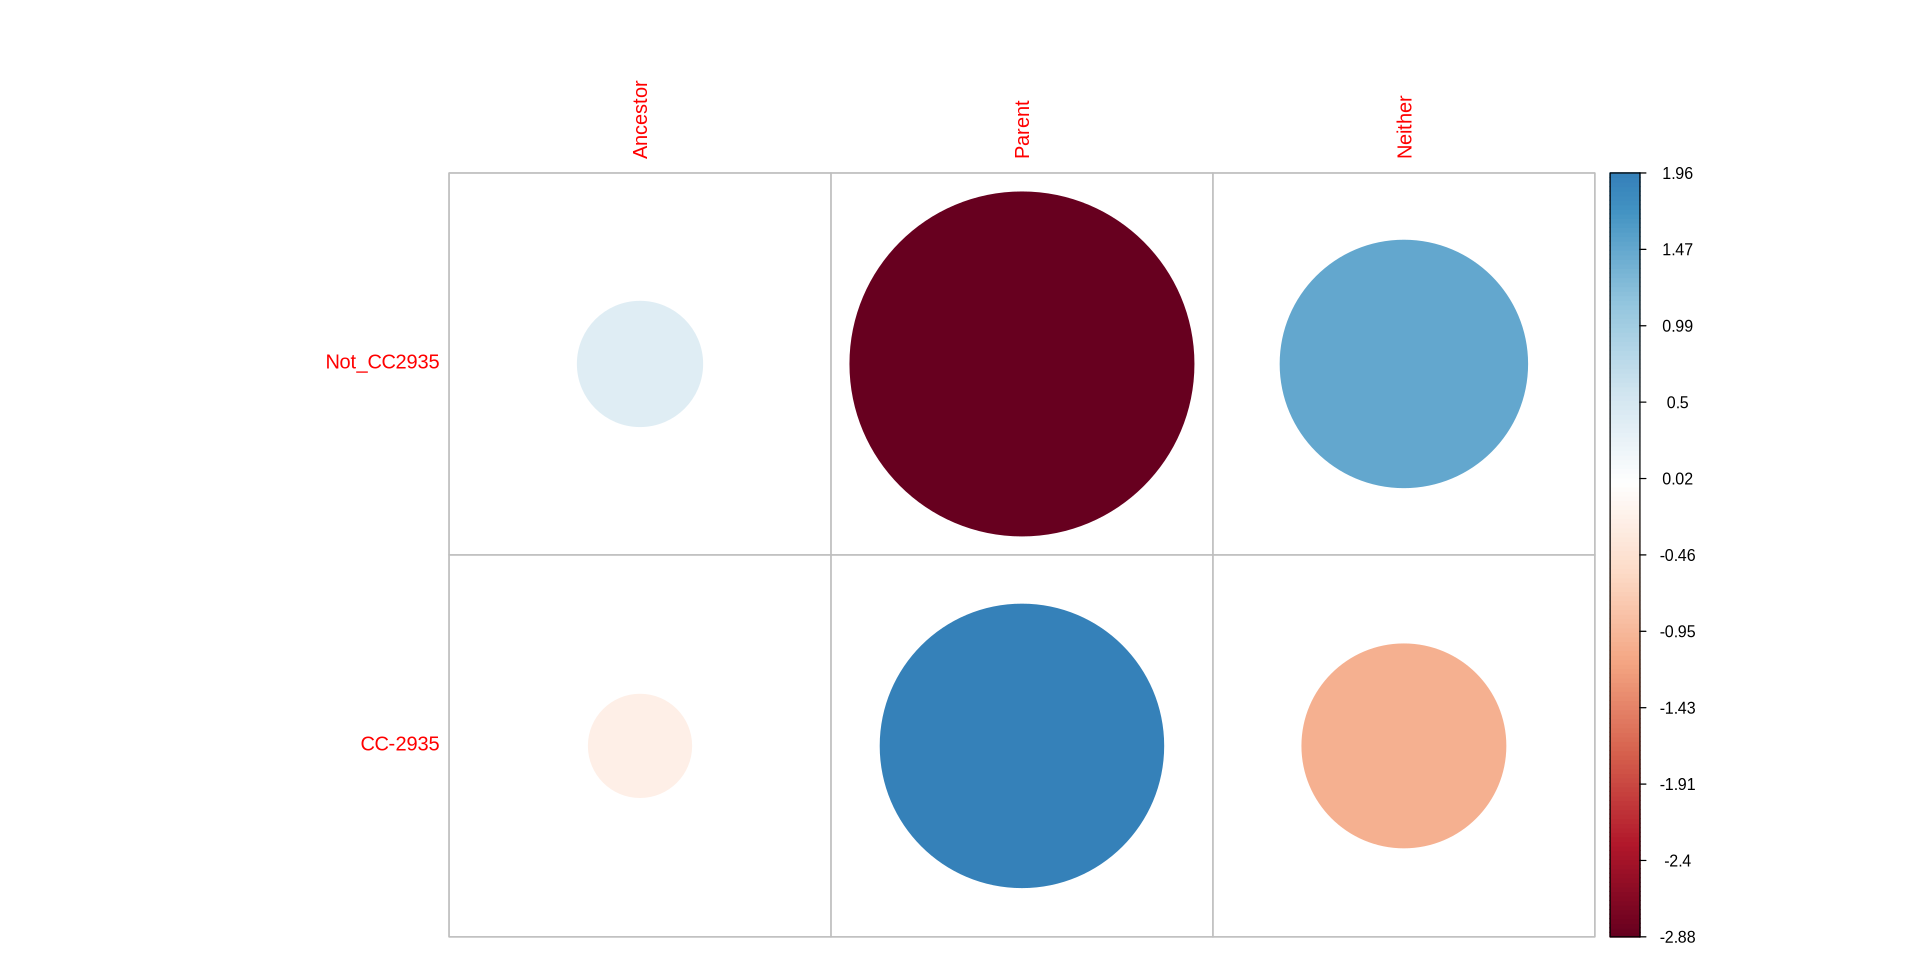

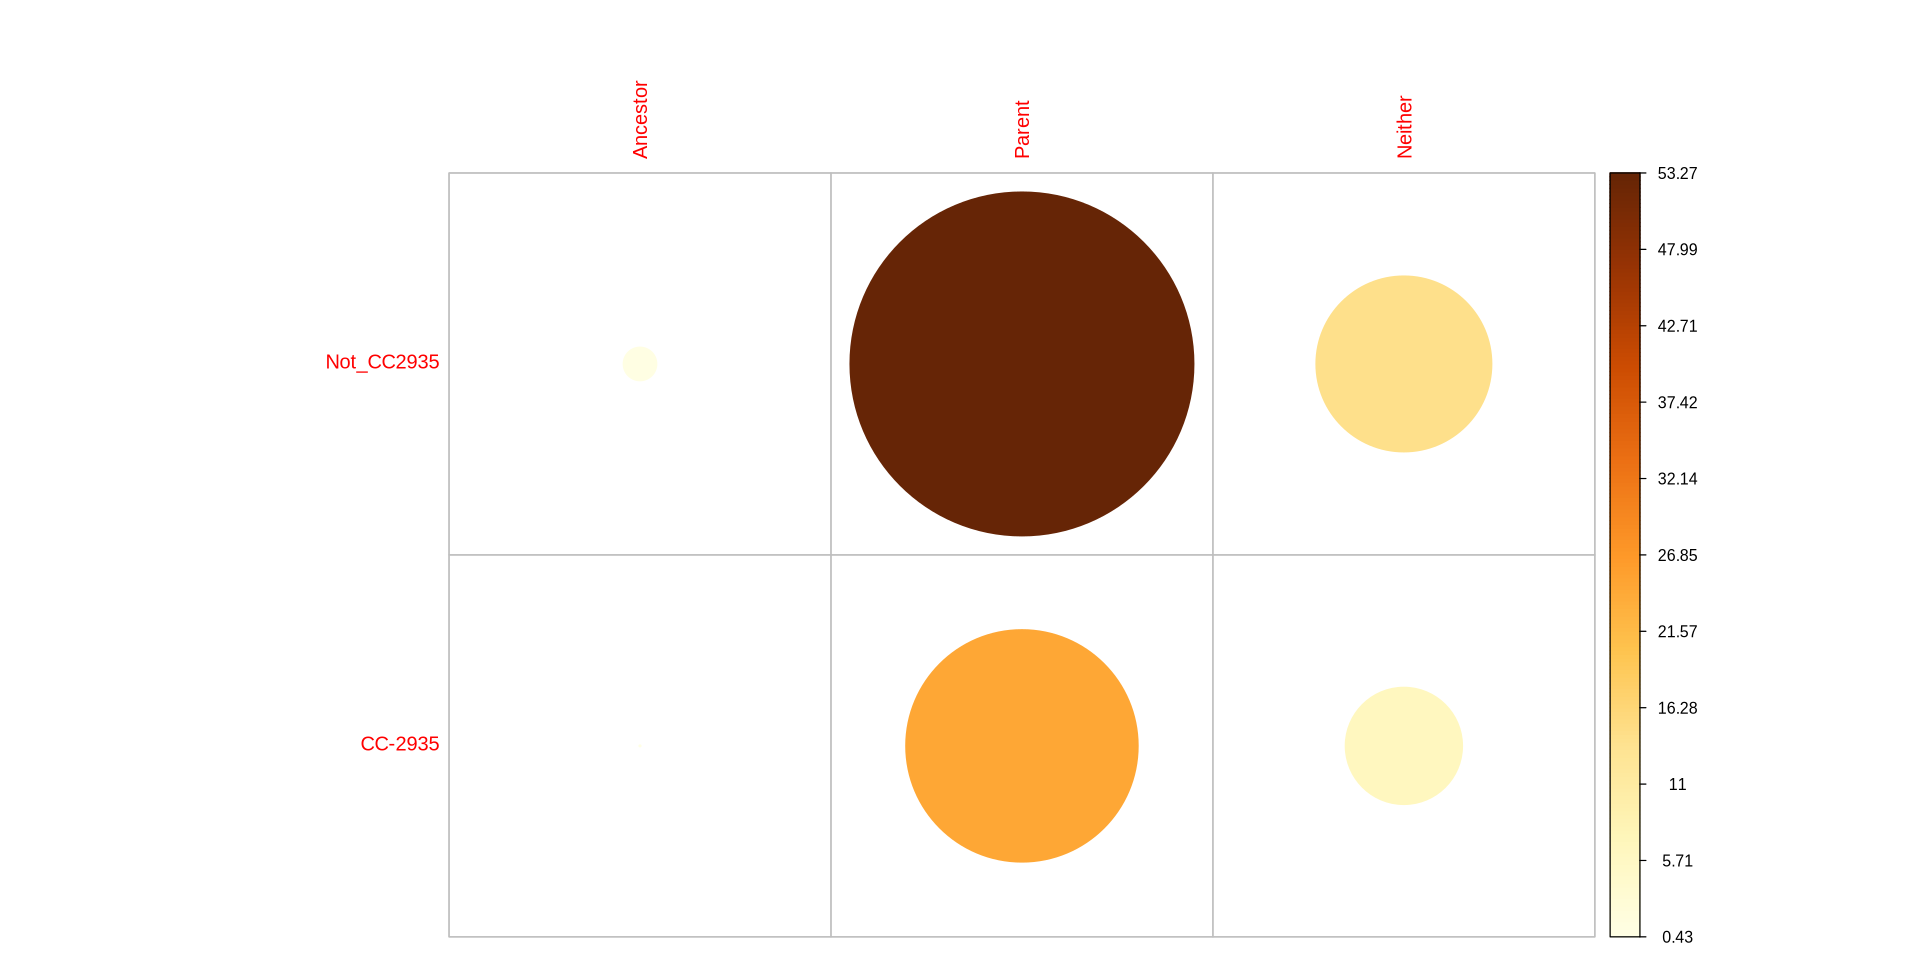

In [54]:
# is the overlap significant between expression and sequence
sources_table <- matrix(table("Genetic_2935" = ancestry_simplified$frac_CC2935_combo, "Expression" = ancestry_simplified$Conc_5),
                        nrow = 2)
rownames(sources_table) <- c("Not_CC2935", "CC-2935")
colnames(sources_table) <- c("Ancestor", "Both", "Neither", "Parent")

sources_table <- data.frame(sources_table) %>% select(Ancestor, Parent, Neither)
chisq <- chisq.test(sources_table)
chisq

#Visualize the residuals
corrplot(chisq$residuals, is.cor = FALSE)

# Visualize the contribution (in %) of a given cell to the total Chi-square score 
contrib <- 100*chisq$residuals^2/chisq$statistic
corrplot(contrib, is.cor = FALSE)

In [55]:
#Merge with plasticity pattern
ancestry_simplified_pat <- merge(ancestry_simplified, HSAP05 %>% select(Inherit), by = 0)
ancestry_simplified_pat <- clean_table(ancestry_simplified_pat)
head(ancestry_simplified_pat)

,Genes,frac_CC2935_29,frac_CC2935_23,frac_CC2935_combo,Conc_5,Inherit
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CHLRE_02g073150v5,CHLRE_02g073150v5,0,0,0,Parent,Constitutive
CHLRE_02g073176v5,CHLRE_02g073176v5,0,0,0,Ancestor,Constitutive
CHLRE_02g073200v5,CHLRE_02g073200v5,0,0,0,Neither,Constitutive
CHLRE_02g073250v5,CHLRE_02g073250v5,0,0,0,Parent,Constitutive
CHLRE_02g073300v5,CHLRE_02g073300v5,0,0,0,Ancestor,Constitutive
CHLRE_02g073350v5,CHLRE_02g073350v5,0,0,0,Ancestor,Constitutive
